In [325]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [326]:
def generate_epsilon_net(epsilon):
    """
    Generate an epsilon-net on a unit sphere in 3D.

    Parameters:
        epsilon (float): The maximum allowable distance between any point
                        on the sphere and the closest point in the epsilon-net.

    Returns:
        np.ndarray: An array of points representing the epsilon-net on the unit sphere.
    """
    # Calculate the number of divisions required based on epsilon
    num_latitude = int(np.pi / epsilon) + 1  # Number of latitude lines
    num_longitude = int(2 * np.pi / epsilon)  # Number of longitude lines

    points = []

    for i in range(num_latitude + 1):
        # Latitude angle: from 0 to pi
        theta = i * np.pi / num_latitude

        for j in range(num_longitude):
            # Longitude angle: from 0 to 2*pi
            phi = j * 2 * np.pi / num_longitude

            # Convert spherical coordinates to Cartesian coordinates
            x = np.sin(theta) * np.cos(phi)
            y = np.sin(theta) * np.sin(phi)
            z = np.cos(theta)

            points.append([x, y, z])

    return np.array(points)

In [335]:
def generate_gaussian_samples(num_samples,mean_col,covariance_matrix):
    """
    Generate 3-dimensional zero-mean Gaussian samples with a random PSD covariance matrix.

    Parameters:
        num_samples (int): The number of samples to generate.

    Returns:
        np.ndarray: An array of Gaussian samples.
    """
    # Generate a random positive semi-definite (PSD) covariance matrix
    # covariance_matrix = np.eye(3)
    # Generate zero-mean Gaussian samples
    samples = np.random.multivariate_normal(mean=mean_col, cov=covariance_matrix, size=num_samples)
    return samples #, covariance_matrix

def algorithm(num_samples,mean_col,covariance_matrix):
    """
    Generate 3-dimensional zero-mean Gaussian samples with a random PSD covariance matrix.
    Scale to unit sphere

    Parameters:
        num_samples (int): The number of samples to generate.

    Returns:
        np.ndarray: An array of Gaussian samples.
    """
    # Generate a random positive semi-definite (PSD) covariance matrix
    # covariance_matrix = np.eye(3)
    # Generate zero-mean Gaussian samples
    samples = np.random.multivariate_normal(mean=mean_col, cov=covariance_matrix, size=num_samples)
    # Normalize each row to have 2-norm = 1
    samples = samples / np.linalg.norm(samples, axis=1, keepdims=True)
    return samples #, covariance_matrix

In [333]:
def regret(point_set,theta_set):
    regret=[]
    for theta in theta_set:
        regret.append(np.linalg.norm(theta)-np.max(np.dot(point_set,theta.reshape(3,1))))
    print(np.average(regret))
    return np.average(regret)

In [374]:
import numpy as np

# Step 1: Define the dominant direction
mean_direction = np.array([1, -1, 1])
mean_direction = mean_direction / np.linalg.norm(mean_direction)  # Normalize

# Step 2: Create two orthonormal basis vectors orthogonal to mean_direction
# Use Gram-Schmidt process
random_vector = np.random.randn(3)
basis_1 = np.cross(mean_direction, random_vector)
basis_1 /= np.linalg.norm(basis_1)

basis_2 = np.cross(mean_direction, basis_1)
basis_2 /= np.linalg.norm(basis_2)

# Step 3: Define the covariance matrix
# Large variance in mean_direction, small in perpendicular directions
cov_matrix = (
    5 * np.outer(mean_direction, mean_direction) +  # Strong variance along mean_direction
    0.5 * np.outer(basis_1, basis_1) +             # Small variance in perpendicular directions
    0.5 * np.outer(basis_2, basis_2)
)

# Print covariance matrix
print("Covariance Matrix:\n", cov_matrix)


Covariance Matrix:
 [[ 2.  -1.5  1.5]
 [-1.5  2.  -1.5]
 [ 1.5 -1.5  2. ]]


In [412]:
# A = np.random.randn(3, 3)
# covariance_matrix = np.dot(A, A.T)  # Ensures the matrix is symmetric and PSD

mean_val=0
mean_col = np.ones(3)*(mean_val)
covariance_matrix = np.array([[ 2.,  -1.5,  1.5],
                            [-1.5,  2.,  -1.5],
                            [ 1.5, -1.5,  2. ]])  # High correlation between x, y, z

num_samples = 100000  # Set the desired number of Gaussian samples
gaussian_samples = generate_gaussian_samples(num_samples,mean_col,covariance_matrix)

epsilon = 0.8  # Set the desired epsilon value
net_points = generate_epsilon_net(epsilon)
output = algorithm(len(net_points),mean_col,covariance_matrix)

print(f"Generated {len(net_points)} geometric epsilon net.")
print(f"Generated {len(output)} measure epsilon net.")
print(f"Generated {len(gaussian_samples)} Gaussian samples.")

Generated 35 geometric epsilon net.
Generated 35 measure epsilon net.
Generated 100000 Gaussian samples.


In [385]:
# Compute the difference and bound vectors
bound = (epsilon**2)/2*np.sqrt(np.matrix.trace(covariance_matrix))
regret_output = regret(output,gaussian_samples) #np.linalg.norm(width(output,gaussian_samples),ord=1)
regret_net = regret(net_points,gaussian_samples)  #np.linalg.norm(width(net_points,gaussian_samples),ord=1)

0.06549579999787532
0.09777608707292702


In [424]:
bound

0.783836717690617

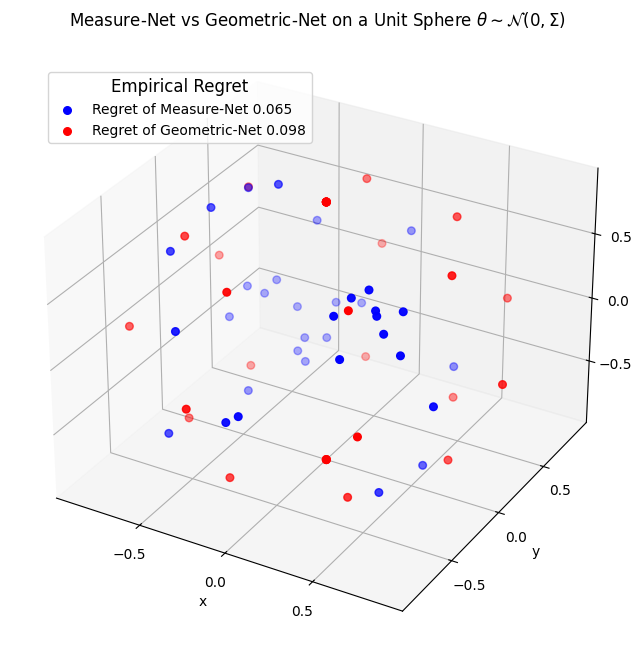

In [425]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set transparent background
fig.patch.set_alpha(0)  # Make the figure background transparent
ax.set_facecolor((1, 1, 1, 0))  # RGBA: (Red, Green, Blue, Alpha), Alpha=0 for transparency

# Plot Measure-Net points
ax.scatter(output[:, 0], output[:, 1], output[:, 2], s=30, color='blue', label="Regret of Measure-Net {:.3f}".format(regret_output))

# Plot Epsilon-Net points
ax.scatter(net_points[:, 0], net_points[:, 1], net_points[:, 2], s=30, color='red', label="Regret of Geometric-Net {:.3f}".format(regret_net))

# Add legend inside the plot
ax.legend(loc="upper left", bbox_to_anchor=(0.05, 0.95), bbox_transform=ax.transAxes,
          title='Empirical Regret',title_fontsize='large')

# Set labels, limits, and title
ax.set_title(r"Measure-Net vs Geometric-Net on a Unit Sphere $\theta\sim\mathcal{N}(0,\Sigma)$")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Set tick labels for each axis
tick_labels = [-0.5, 0, 0.5]
ax.set_xticks(tick_labels)
ax.set_yticks(tick_labels)
ax.set_zticks(tick_labels)

# Save plot as a PDF without margins
plt.savefig("net0.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

plt.show()


In [426]:
# Step 1: Generate points on the unit sphere
num_samples = 500
samples = np.random.multivariate_normal(mean=mean_col, cov=covariance_matrix, size=num_samples)
samples /= np.linalg.norm(samples, axis=1, keepdims=True)  # Normalize to unit sphere

# Step 2: Generate a grid of points on the unit sphere
phi = np.linspace(0, np.pi, 100)   # Latitude (from 0 to pi)
theta = np.linspace(0, 2*np.pi, 200)  # Longitude (from 0 to 2*pi)
phi, theta = np.meshgrid(phi, theta)

# Convert spherical coordinates to Cartesian for the grid
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)
grid_points = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T  # Reshape into (N,3)

# Step 3: Compute density using KDTree for smoothing
tree = cKDTree(samples)
num_neighbors = 30  # Smoothing parameter
distances, _ = tree.query(grid_points, k=num_neighbors)
density = num_neighbors / np.sum(distances, axis=1)  # Inverse distance approximation

# Step 4: Normalize density and reshape
density -= density.min()
density /= density.max()
density = density.reshape(x.shape)  # Reshape to match the grid

# Step 5: Create a custom colormap (white to green)
colors = [(1, 1, 1, 0), (0, 1, 0, 1)]  # RGBA: (White transparent → Green)
custom_cmap = mcolors.LinearSegmentedColormap.from_list("white_to_green", colors, N=256)

# Step 6: Plot the smooth heatmap on the unit sphere
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set transparent background
fig.patch.set_alpha(0)  # Make the figure background transparent
ax.set_facecolor((1, 1, 1, 0))  # RGBA: (Red, Green, Blue, Alpha), Alpha=0 for transparency

# Plot sphere with color from density
ax.plot_surface(x, y, z, facecolors=custom_cmap(density), rstride=1, cstride=1, antialiased=True, alpha=0.9)

# Set labels, limits, and title
ax.set_title(r"Importance Measure $q$ on a Unit Sphere")
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Set tick labels for each axis
tick_labels = [-0.5, 0, 0.5]
ax.set_xticks(tick_labels)
ax.set_yticks(tick_labels)
ax.set_zticks(tick_labels)

# Save plot as a PDF without margins
plt.savefig("measureq0.pdf", format="pdf", bbox_inches='tight', pad_inches=0, transparent=True)

plt.show()

(array([2.200e+01, 2.474e+03, 4.244e+03, 2.038e+03, 7.750e+02, 2.990e+02,
        9.400e+01, 3.600e+01, 1.400e+01, 4.000e+00]),
 array([-0.06475491, -0.02671491,  0.01132509,  0.0493651 ,  0.0874051 ,
         0.12544511,  0.16348511,  0.20152511,  0.23956512,  0.27760512,
         0.31564512]),
 <BarContainer object of 10 artists>)

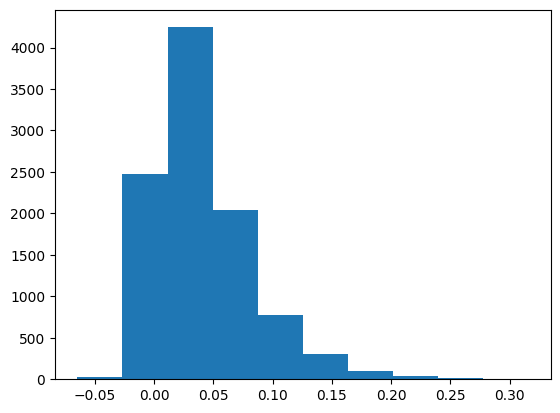

In [29]:
plt.hist(difference)

(array([1250., 2715., 2645., 1758.,  984.,  416.,  169.,   47.,   12.,
           4.]),
 array([0.02526495, 0.53425537, 1.04324579, 1.5522362 , 2.06122662,
        2.57021703, 3.07920745, 3.58819786, 4.09718828, 4.60617869,
        5.11516911]),
 <BarContainer object of 10 artists>)

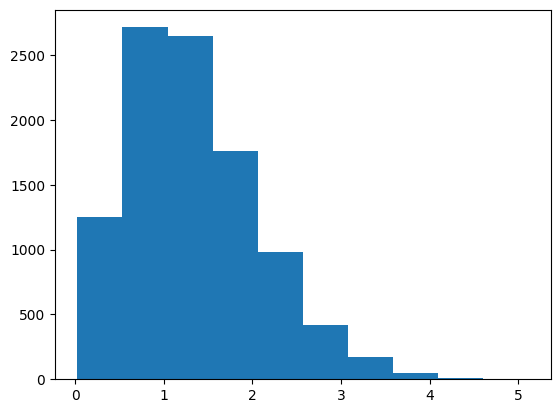

In [133]:
plt.hist(bound)